## Imports and Data Access

In [118]:
%pip install kneed

Note: you may need to restart the kernel to use updated packages.


In [119]:
%pip install dython

Note: you may need to restart the kernel to use updated packages.


In [120]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import dython
from datetime import datetime as dt
from sklearn.preprocessing import quantile_transform, LabelEncoder
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn import metrics
import matplotlib.cm as cm

pd.set_option("max_columns", None)
pd.set_option("max_rows", None)

In [121]:
# Read in the data
df = pd.read_csv("marketing_campaign.csv", "\t")

## Exploratory Analysis

In [122]:
df.shape

(2240, 29)

In [123]:
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

There are a small number of nulls in the income column (24). I have no way of knowing whether these are customers who have no income or whether the data is missing. For this reason, I will decide not to lose any data, and I will replace the nulls with zeros as this is a valid scenario. 

In [124]:
# Check for any NaNs and replace with zeros
df.Income = df.Income.fillna(0)

In [125]:
# Drop Z_CostContact and Z_Revenue as they appear to just be constants
df = df.drop(["Z_CostContact", "Z_Revenue"], axis=1)

## Feature Engineering

In [126]:
# Define the year today
today_year = dt.today().year
today_date = dt.today()

# Create age feature
df['age'] = today_year - df['Year_Birth']

# Create has_child feature
df['has_child'] = np.where(df['Kidhome'] > 0, 1, 0)

# Create a total_spend feature
df['total_spend'] = df['MntWines']+ df['MntFruits']+ df['MntMeatProducts']+ df['MntFishProducts']+ df['MntSweetProducts']+ df['MntGoldProds']

# Create a total_number_purchases feature
df['total_purchases'] = df['NumWebPurchases']+ df['NumCatalogPurchases']+ df['NumStorePurchases']

# Replace number of purchases with fraction of purchases by location and fraction of purchase w/deals
# df['purchases_with_deals'] = df["NumDealsPurchases"]/df['total_purchases']
# df['web_purchase_fraction'] = df["NumWebPurchases"]/df['total_purchases']
# df['catalog_purchase_fraction'] = df["NumCatalogPurchases"]/df['total_purchases']
# df['store_purchase_fraction'] = df["NumStorePurchases"]/df['total_purchases']

# Combine the Accepted Promos into a Count
df["promos_accepted"] = df["AcceptedCmp1"] + df["AcceptedCmp2"] + df["AcceptedCmp3"] + df["AcceptedCmp4"] + df["AcceptedCmp5"] + df["Response"]

# Is it worth grouping marital statuses together? 
df["Marital_Status"] = df["Marital_Status"].replace({'Divorced':'Single', 'Single':'Single', 'Alone':'Single', 'Widow':'Single', 'Absurd':'Single', 'YOLO':'Single','Married':'Married','Together':'Married'})

# Deal with the date of customer's enrolment (create tenure)
today_date = dt.today()
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
df['tenure'] = (today_date - df['Dt_Customer']).dt.days

# Improve education groupings
df['Education']=df['Education'].replace({'Basic':'Basic','2n Cycle':'Postgrad','Graduation':'Bachelor','Master':'Postgrad','PhD':'Postgrad'})


In [127]:
# Check for any NaNs arising from division and replace with zeros
df = df.fillna(0)

In [128]:
# Check for any data quality issues / zero division errors caused above
df.iloc[df.values==np.inf]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,age,has_child,total_spend,total_purchases,promos_accepted,tenure


In [129]:
## Some data quality issues arise with some of the feature creation above
# NumDealsPurchases = 15 but total_purchases = 0, giving np.inf datatype which cannot be used
# As I believe this to be a data quality issue I will drop these instances
df.drop([1232, 1829], axis=0, inplace=True)
df.iloc[df.values==np.inf]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,age,has_child,total_spend,total_purchases,promos_accepted,tenure


In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2238 entries, 0 to 2239
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2238 non-null   int64         
 1   Year_Birth           2238 non-null   int64         
 2   Education            2238 non-null   object        
 3   Marital_Status       2238 non-null   object        
 4   Income               2238 non-null   float64       
 5   Kidhome              2238 non-null   int64         
 6   Teenhome             2238 non-null   int64         
 7   Dt_Customer          2238 non-null   datetime64[ns]
 8   Recency              2238 non-null   int64         
 9   MntWines             2238 non-null   int64         
 10  MntFruits            2238 non-null   int64         
 11  MntMeatProducts      2238 non-null   int64         
 12  MntFishProducts      2238 non-null   int64         
 13  MntSweetProducts     2238 non-nul

In [131]:
# Select just relevant colums
df_ID = df['ID']
df = df.drop(["ID", "Year_Birth", "Kidhome", "Teenhome", "Dt_Customer", "MntWines", "MntFruits",
              "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds", "AcceptedCmp1", "AcceptedCmp2",
              "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5", "Response"], axis=1)

### Encoding

In [132]:
le = LabelEncoder()
cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
for i in cat_cols:
    df[i] = le.fit_transform(df[[i]])

C:\Users\rhian\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [134]:
# Re-Run Identification of Binary / Continious Features and Add Categorical to Binary Features
b_feature_names = [col for col in df if df[col].dropna().value_counts().index.isin([0,1]).all()]
cat_feature_names = b_feature_names + ["Education", "Marital_Status"]
c_feature_names = [col for col in df.columns if col not in cat_feature_names]

### Scale Continuous Features

In [135]:
# access continous features
cont_features = df[c_feature_names]

# apply quantile transform
qc_features = pd.DataFrame(
  quantile_transform(cont_features, output_distribution='normal', ignore_implicit_zeros=True),
  columns=cont_features.columns,
  copy=True)

# show transformed data
qc_features

C:\Users\rhian\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_data.py:2503: UserWarning: 'ignore_implicit_zeros' takes effect only with sparse matrix. This parameter has no effect.
  warnings.warn("'ignore_implicit_zeros' takes effect only with"


,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,age,total_spend,total_purchases,promos_accepted,tenure
0,0.251036,0.240671,0.648724,1.298271,2.033104,-0.253606,0.576075,0.848075,1.404533,1.189522,0.880888,1.994971
1,-0.170185,-0.279606,0.163824,-1.278137,-0.325577,-1.562721,-0.216204,1.118711,-1.471555,-1.233962,-5.199338,-1.738731
2,0.839048,-0.618059,-0.715218,1.298271,0.111890,1.044409,-0.514923,0.337506,0.374690,0.873515,-5.199338,-0.148584
3,-1.100268,-0.618059,0.163824,-0.633317,-5.199338,-0.253606,0.134645,-1.242061,-0.888309,-0.592444,-5.199338,-1.918441
4,0.255429,1.629992,1.362078,0.440383,0.378977,0.270485,-0.216204,-0.981540,0.043068,0.156199,-5.199338,-0.728240
5,0.410059,-0.953493,0.163824,0.723343,0.611996,1.044409,0.134645,0.211070,0.318693,0.873515,-5.199338,-0.212353
6,0.160942,-0.377630,1.037937,1.018778,0.378977,0.462610,0.134645,-0.086674,0.216269,0.482248,-5.199338,0.969427
7,-0.748135,-0.425228,0.163824,0.148584,-5.199338,-0.253606,1.184447,-1.331018,-0.304084,-0.287442,-5.199338,-0.089192
8,-0.911229,-0.849874,-0.715218,-0.198258,-5.199338,-1.562721,1.985876,-0.353487,-1.004131,-0.864365,0.880888,0.120906
9,-2.205423,0.489307,-0.715218,-1.278137,-5.199338,-5.199338,5.199338,1.593219,-0.935852,-2.696511,0.880888,-0.925332


In [136]:
qc_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2238 entries, 0 to 2237
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Income               2238 non-null   float64
 1   Recency              2238 non-null   float64
 2   NumDealsPurchases    2238 non-null   float64
 3   NumWebPurchases      2238 non-null   float64
 4   NumCatalogPurchases  2238 non-null   float64
 5   NumStorePurchases    2238 non-null   float64
 6   NumWebVisitsMonth    2238 non-null   float64
 7   age                  2238 non-null   float64
 8   total_spend          2238 non-null   float64
 9   total_purchases      2238 non-null   float64
 10  promos_accepted      2238 non-null   float64
 11  tenure               2238 non-null   float64
dtypes: float64(12)
memory usage: 209.9 KB


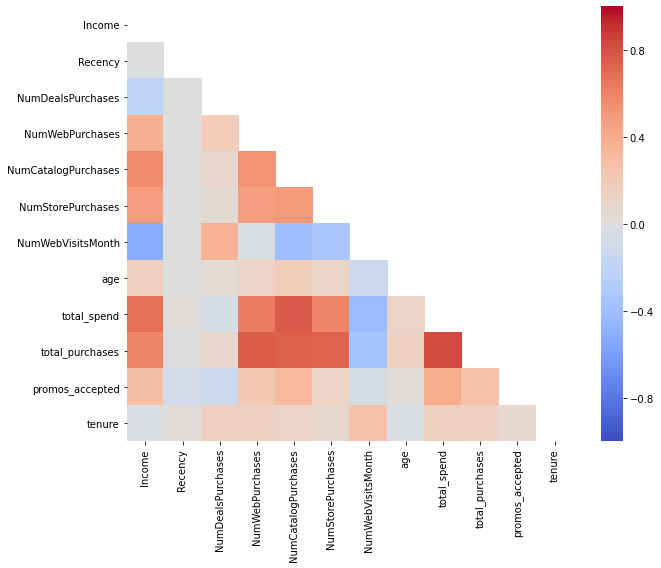

In [137]:
# Get correlation matrix
qc_features_corr = qc_features.corr() 

# use a mask to remove top-half of heatmap
top_mask = np.zeros(qc_features_corr.shape, dtype=bool)
top_mask[np.triu_indices(len(top_mask))] = True

plt.figure(figsize=(10,8))

# Plot heatmap
hmap = sns.heatmap(
  qc_features_corr,
  cmap = 'coolwarm',
  vmin =  1.0, 
  vmax = -1.0,
  mask = top_mask
  )

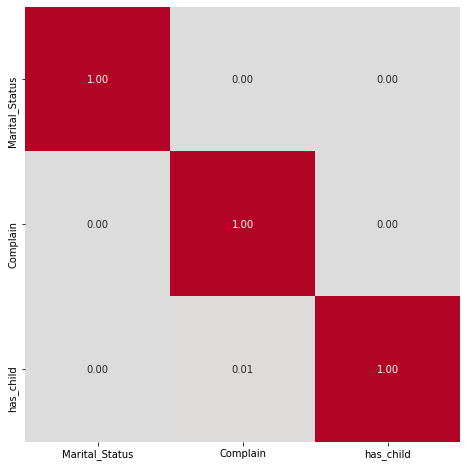

In [138]:
# Look at correlations between binary variables with Theil's U

_ = dython.nominal.associations(
  df[b_feature_names], 
  nominal_columns='all',
  nom_nom_assoc='theil',
  figsize=(10,8),
  cmap='coolwarm',
  vmax=1.0,
  vmin=0.0,
  cbar=False
  )

## Apply Dimensionality Reduction

In [139]:
variance_ratio = {}

for i in range(1, len(qc_features.columns)+1):
    pca = PCA(n_components=i)
    pca.fit(qc_features)
    variance_ratio[f'n_{i}'] = pca.explained_variance_ratio_.sum()
    
variance_ratio

{'n_1': 0.4472588220543254,
 'n_2': 0.6717340760173219,
 'n_3': 0.7452988275480039,
 'n_4': 0.8033776579587777,
 'n_5': 0.8541442784267022,
 'n_6': 0.8917129352645513,
 'n_7': 0.924544336190693,
 'n_8': 0.9543556101742696,
 'n_9': 0.9753326690599637,
 'n_10': 0.9889319769446032,
 'n_11': 0.9961301757988493,
 'n_12': 1.0}

In [140]:
pca = PCA(n_components =6, random_state = 42)

pca.fit(qc_features)
data_pca = pd.DataFrame(pca.transform(qc_features), 
                        columns = (["PC1", "PC2", "PC3", "PC4", "PC5", "PC6"]))

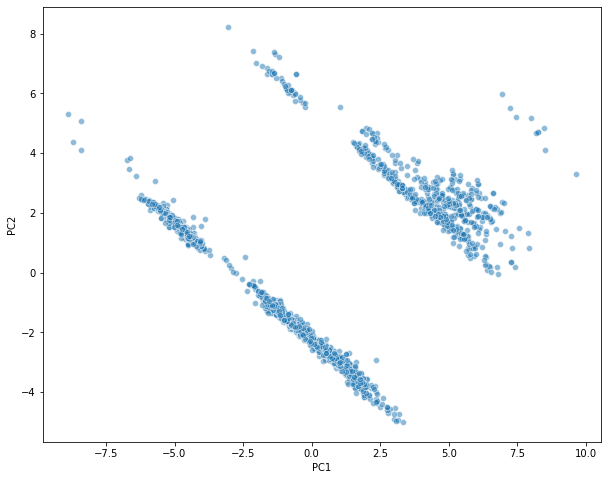

In [141]:
fig, ax = plt.subplots(figsize=(10,8))

_ = sns.scatterplot(
  data=data_pca,
  x='PC1',
  y='PC2',
  alpha=0.5,
  ax=ax
  )

## Apply DBSCAN

1.8325294382501265


<Figure size 360x360 with 0 Axes>

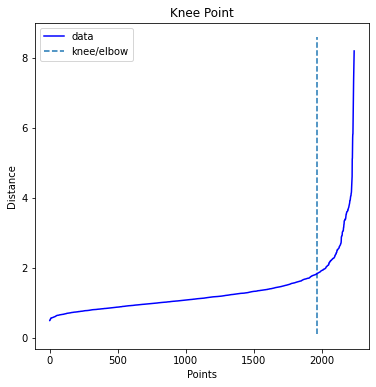

In [142]:
# parameter tuning for eps
from sklearn.neighbors import NearestNeighbors
nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(data_pca)
distances, indices = neighbors.kneighbors(data_pca)
distances = np.sort(distances[:,10], axis=0)

from kneed import KneeLocator
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
print(distances[knee.knee])
eps=distances[knee.knee]

In [143]:
# dbscan clustering
from numpy import unique
from numpy import where
from sklearn.cluster import DBSCAN
from matplotlib import pyplot

distances = ['euclidean', 'minkowski', 'hamming', 'l1', 'l2', 'manhattan']

for dist in distances:
    model = DBSCAN(eps=eps, min_samples= 12)
    dbscan = model.fit_predict(data_pca)
    clusters = unique(dbscan)
    score_dbsacn_s = metrics.silhouette_score(data_pca, dbscan, metric=dist)
    print('Silhouette Score: %.4f' % score_dbsacn_s)

Silhouette Score: 0.3482
Silhouette Score: 0.3482
Silhouette Score: 0.0005
Silhouette Score: 0.3420
Silhouette Score: 0.3482
Silhouette Score: 0.3420


Performance not as good as other algorithms. Discard.